# 4. Vorlesung

In [6]:
import wntr
import pandas as pd
import matplotlib.pyplot as plt
from helper import to_cbs, to_ls, plot_results, da

## Aufgabe 1

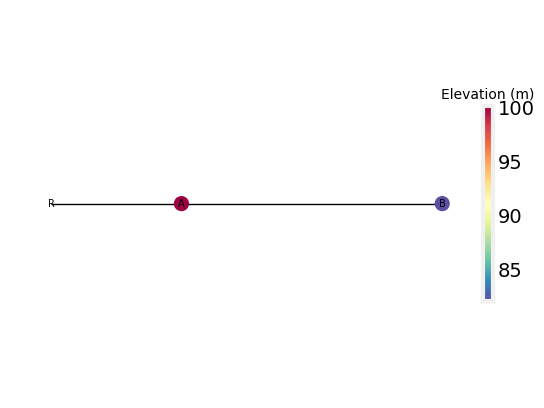

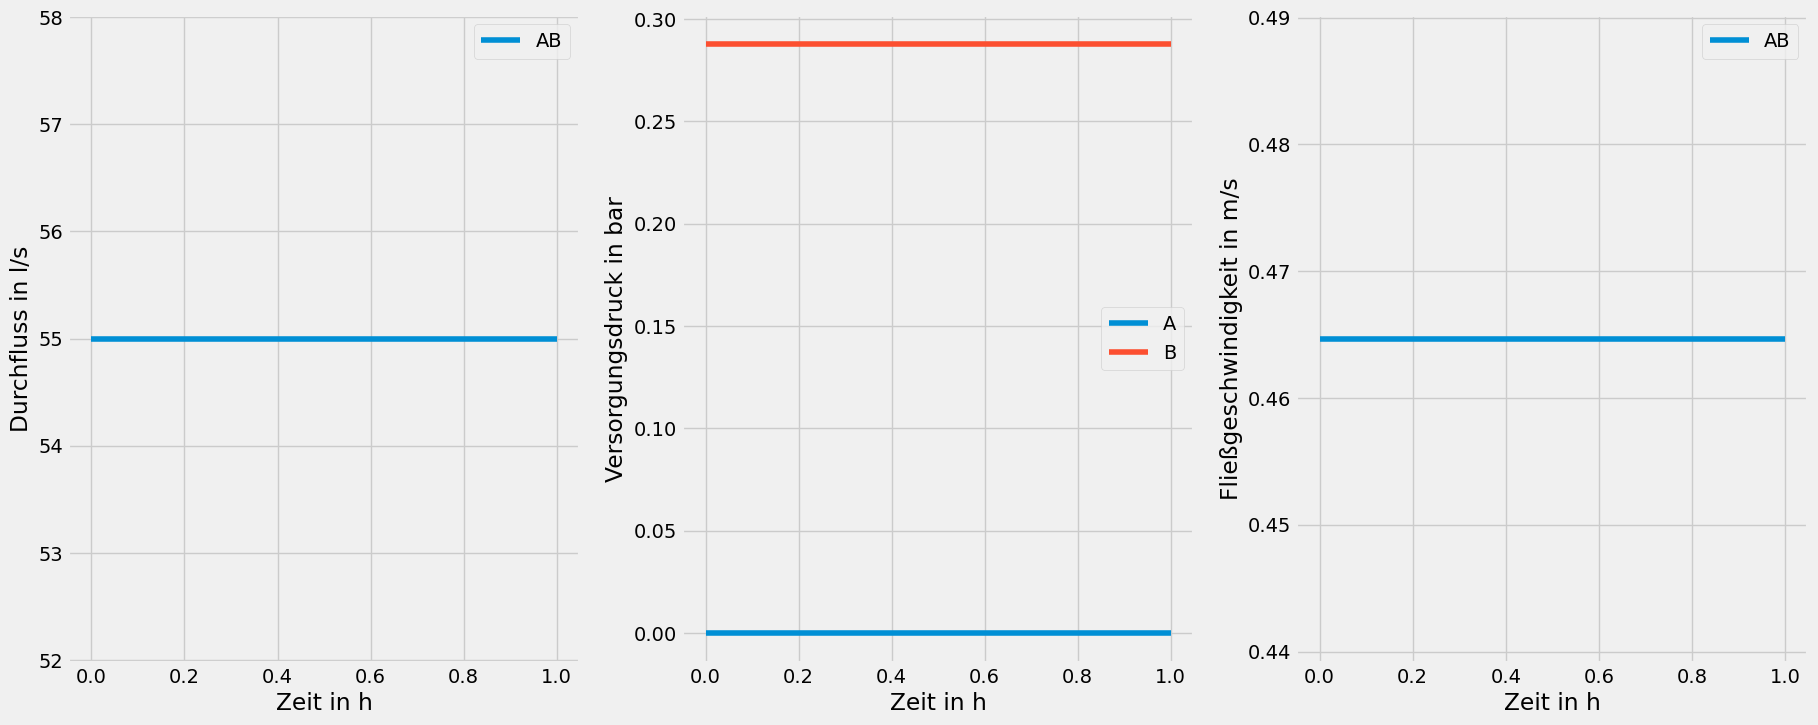

In [7]:
# neues Modell erstellen
wn = wntr.network.WaterNetworkModel()
wn.options.hydraulic.demand_model = 'PDD'


wn.add_pattern('pat', [1])

# Knoten generieren
wn.add_junction('A', base_demand=0, demand_pattern='pat', elevation=100, coordinates=(0,0))
wn.add_junction('B', base_demand=to_cbs(55), demand_pattern='pat', elevation=82, coordinates=(2,0))

# Rohrnetzwerk erstellen
r = 100
wn.add_pipe('AB', 'A', 'B', length=7280, diameter=da[250], roughness=r )


# Hochbehälter
wn.add_reservoir('R', base_head=100, coordinates=(-1,0))
wn.add_pipe('TA', 'R', 'A', length=1, diameter=da[315], roughness=100)

# Simulation
wn.options.time.duration = 1*3600
sim = wntr.sim.WNTRSimulator(wn)
results = sim.run_sim()

# Ergebnisse darstellen
plot_results(wn, results, drop_junction=['R'], drop_link=['TA'])

In [8]:
to_ls(results.node['demand'])

A     B     R
0     0.0  55.0 -55.0
3600  0.0  55.0 -55.0

# Einluss des Leitungsdurchmessers auf Druckverhältnisse in B

In [9]:
res = []
v = []

for di in da.keys(): #in mm
    wn = wntr.network.WaterNetworkModel()
    wn.options.hydraulic.demand_model = 'PDD'


    wn.add_pattern('pat', [1])

    # Knoten generieren
    wn.add_junction('A', base_demand=0, demand_pattern='pat', elevation=100, coordinates=(0,0))
    wn.add_junction('B', base_demand=to_cbs(55), demand_pattern='pat', elevation=82, coordinates=(2,0))

    # Rohrnetzwerk erstellen
    r = 100
    wn.add_pipe('AB', 'A', 'B', length=7280, diameter=da[di], roughness=r )


    # Hochbehälter
    wn.add_reservoir('R', base_head=100, coordinates=(-1,0))
    wn.add_pipe('TA', 'R', 'A', length=1, diameter=da[315], roughness=100)

    # Simulation
    wn.options.time.duration = 1*3600
    sim = wntr.sim.WNTRSimulator(wn)
    results = sim.run_sim()

    pr = results.node['pressure']
    
    pr[pr<0] = pd.NA
    pr['di'] = di
    
    v_r = results.link['velocity']
    v_r['di'] = di
    
    res.append(pr)
    v.append(v_r)
    
    #break
res = pd.concat(res)
res = res.reset_index().set_index(['index', 'di']).sort_index()

v = pd.concat(v)
v = v.reset_index().set_index(['index', 'di']).sort_index()

In [14]:
fig,axs = plt.subplots(1,2, sharex=True, figsize=(20,10))

B = res.loc[3600]['B'].dropna()
ax = B.div(10).plot(ax=axs[0], marker='o')
ax.set_ylabel('Versorgungsdruck in bar')
ax.set_xlabel('Innendurchmesser in mm')

ax = v.loc[3600]['AB'].loc[B.index].plot(ax=axs[1], c='C3', marker='o')
ax.set_ylabel('Fließgeschwindigkeit in m/s')
ax.set_xlabel('Innendurchmesser in mm')

plt.show()